<a href="https://colab.research.google.com/github/yjmd2222/Section-3-Project/blob/main/Section_3_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 지금 당신의 자세는 올바른가요?

오랫동안 올바른 자세를 유지하기란 쉽지 않다. 사람이 느끼기에 편한 자세로 자연스럽게 바뀌기 마련인데, 올바른 자세를 유지하는 근육의 긴장이 풀리면서 비슷하지만 편한 자세를 유지하기 위해 보상작용으로 다른 근육의 긴장도가 쌓이게 되고, 지속되면 체형에 변화도 생긴다.

책상에 오래 앉아 있으면 거북목, 편평등 등의 체형 변화와 근육 약화 및 경직을 야기할 수 있다. 스마트폰을 오래 보는 것도 마찬가지이다. 오래 서 있으면 짝다리로 서게 되고, 평발과 골반 비대칭이 생길 수 있다.

적절한 운동과 중간마다 스트레칭으로 이를 예방하자는 말들이 많은데, 근본적으로 올바른 자세를 의식하고 유지할 수 있는 사전 지식과 근력을 전제로 올바른 자세를 유지하는 것이 정답이다.

딥러닝 컴퓨터 비전 분야 중 움직임 분석에 탁월한 MoveNet을 사용해보고자 한다. 

장시간 올바르지 않은 자세로 쌓인 피로와 통증 해소를 위한 의료시설 방문 횟수, 즉 비용을 줄이고, 즐거운 일상생활을 할 수 있기를 기대한다. (물론 앞서 언급했듯이 올바른 자세를 의식하고 유지할 수 있는 사전 지식과 근력이 있어야 하므로 올바른 자세에 더해 운동은 필수지만 이는 별개의 문제로 넘어가겠다.)

## 데이터 수집

컴퓨터에 연결된 웹캠으로부터 사진을 저장하여 데이터를 수집한다.
수집 부분에서는 현재로서 코랩과 호환되지 않는다.

자세는 옆모습으로 촬영한다. 그런데 이것은 MoveNet의 기본 가정에 위배된다: MoveNet은 몸의 17개 포인트를 찾아준다. 옆모습만 보이면 찾고자 하는 17개의 지점을 정확히 찾을 수 없는 문제가 있다. 하지만 전체를 진행해본 결과 앞모습이나 대각선 구도가 아닌 옆 모습을 촬영했을 때 등과 목의 자세를 더욱 잘 구별할 수 있었기 때문에 옆모습으로 촬영할 것을 추천한다.

In [1]:
###################################
# colab 호환 안 됨. 로컬에서 실행 #
###################################
import cv2
import os
from datetime import datetime

# 저장 경로
ROOT = r'C:\Users\jinmo\Documents\GitHub\Section-3-Project'
# ROOT = r'Workspace 경로를 입력하세요'

# 모델 학습 및 평가를 위한 이미지 저장 함수
def prepare_data(path=ROOT, posture='default', x=100, num_imgs=500):
    '''
    path: 작업 경로
    posture: 폴더 이름으로 저장할 자세\n
    x: 이미지 캡쳐할 주기 in miliseconds\n
    num_imgs: 캡쳐할 이미지 개수
    '''
    # posture 폴더 생성 작업
    parentdir = os.path.join(path, r'webcam/poses')
    if not os.path.exists(parentdir): os.makedirs(parentdir)
    os.chdir(parentdir)

    if not os.path.exists(posture):
        os.mkdir(posture)

    os.chdir(os.path.join(parentdir, posture))
    
    # 저장 이미지 이름 enumerator
    i = 1
    
    # base ticks
    elapsed = wait = 0
    
    # access webcam
    video = cv2.VideoCapture(0)
    
    
    while True:
        # Read video by read() function and it
        # will extract and  return the frame
        ret, img = video.read()
    
        # Put current DateTime on each frame
        font = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, str(datetime.now()), (20, 40),
                    font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
        # Display the image
        cv2.imshow('live video', img)
    
        # wait for user to press any key
        key = cv2.waitKey(100)
    
        # wait variable is to calculate waiting time
        wait = wait+100
        elapsed += 100
    
        # press 'q' to quit
        if key == ord('q'):
            break
        # when it reaches to x milliseconds
        # we will save that frame in given folder
        if wait == x:
            filename = 'Frame_'+str(i)+'.jpg'
            
            # Save the images in given path
            cv2.imwrite(filename, img)
            i = i+1
            wait = 0

        # 이미지 num_imgs장 추출 후 break
        if elapsed == num_imgs * x:
            break
    
    # close the camera
    video.release()
    
    # close open windows
    cv2.destroyAllWindows()
    # reset current dir
    os.chdir(path)

In [ ]:
# prepare_data(posture='testing') # 웹캠 및 저장 작동하는지 테스트

아래는 정상 자세, 거북목, 편평등, 그리고 의자에 누워 앉는 자세로 구성되어 있다. 각각 약 50초간 500개의 프레임을 기록 후 자동으로 종료한다. 자세를 추가해주거나, 별도의 이름으로 자세를 저장하고 싶다면 `posture`의 입력값을 변경할 수 있다.

In [52]:
prepare_data(posture='normal')

![정상 자세](https://raw.githubusercontent.com/yjmd2222/Section-3-Project/main/webcam/poses/normal/Frame_1.jpg)

In [53]:
prepare_data(posture='forward_head') # 거북목

In [54]:
prepare_data(posture='leaning') # 눕듯이 등받이 기댐

![누운 자세](https://raw.githubusercontent.com/yjmd2222/Section-3-Project/main/webcam/poses/leaning/Frame_1.jpg)

In [80]:
# 일반화 성능 높이기 위해 여러 번 사진 수집할 경우 수집 사진 이름 변경
def rename_files(dirname, num_imgs=500):
    os.chdir(dirname)
    for _, __, files in os.walk(dirname):
        for file in files:
            os.rename(file, file[:6] + str(int(file[6:-4]) + num_imgs) + '.jpg')

# 전처리

## MoveNet 및 분류에 필요한 라이브러리 목록

In [ ]:
# !pip install -q opencv-python

In [2]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

In [3]:
#@title MoveNet 함수
#@markdown 처음 실행 시 아래 두 줄 uncomment 필수
# !wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
# !git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  """Runs detection on an input image.
 
  Args:
    input_tensor: A [height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the model should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A Person entity detected by the MoveNet.SinglePose.
  """
  image_height, image_width, channel = input_tensor.shape
 
  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [4]:
#@title 추출한 이미지에 포즈 표기 함수

def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  """Draws the keypoint predictions on image.
 
  Args:
    image: An numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.
 
  Returns:
    An numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])
  
  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [5]:
#@title MoveNet 포즈 결과 .csv로 변환하는 클래스

class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
    """Creates a preprocessor to detection pose from images and save as CSV.

    Args:
      images_in_folder: Path to the folder with the input images. It should
        follow this structure:
        yoga_poses
        |__ downdog
            |______ 00000128.jpg
            |______ 00000181.bmp
            |______ ...
        |__ goddess
            |______ 00000243.jpg
            |______ 00000306.jpg
            |______ ...
        ...
      images_out_folder: Path to write the images overlay with detected
        landmarks. These images are useful when you need to debug accuracy
        issues.
      csvs_out_path: Path to write the CSV containing the detected landmark
        coordinates and label of each image that can be used to train a pose
        classification model.
    """
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    # Get list of pose classes and print image statistics
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          
          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          
          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          # if not should_keep_image:
          #   self._messages.append('Skipped ' + image_path +
          #                         '. No pose was confidentlly detected.')
          #   continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        
          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      
    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

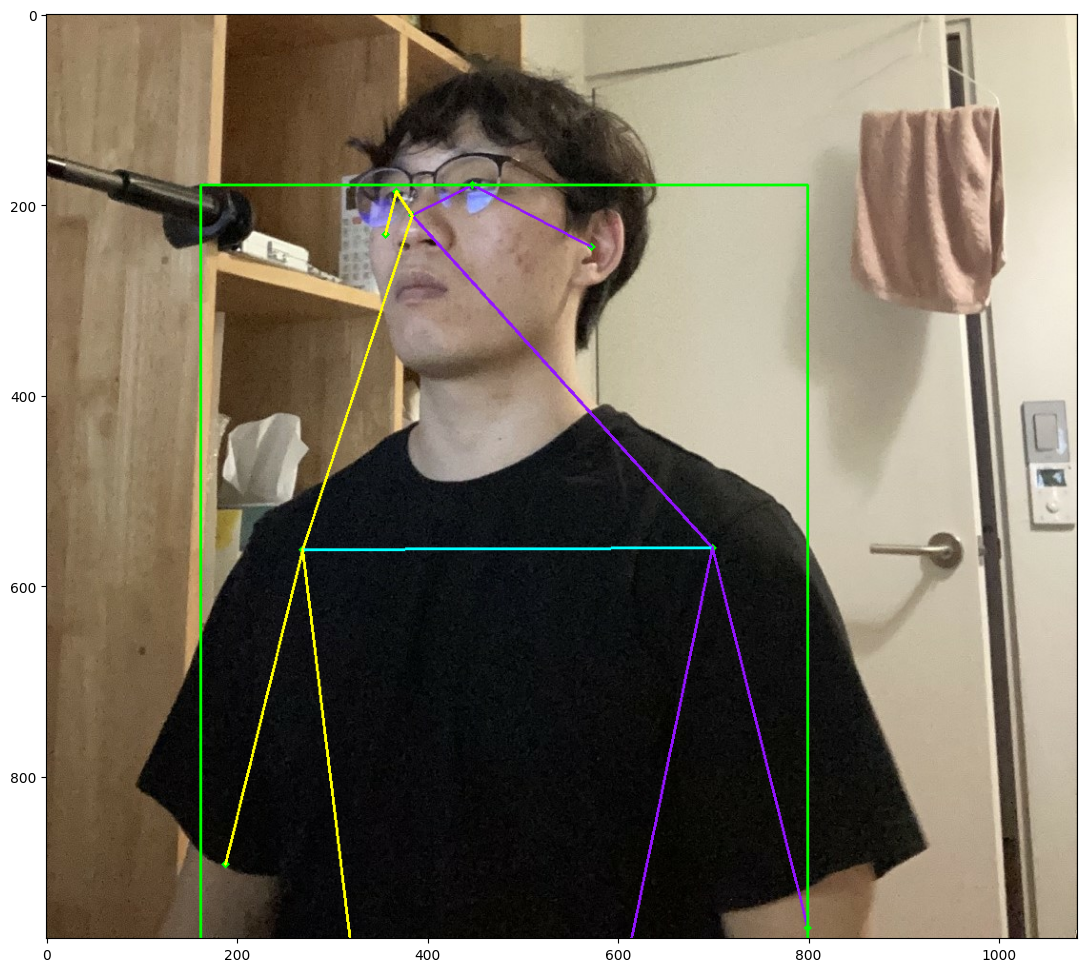

In [100]:
# MoveNet 전처리 사진 테스트
image = tf.io.read_file(r"C:\Users\jinmo\Documents\GitHub\Section-3-Project\test_image_diag.jpg")
# image = tf.io.read_file(r"C:\Users\jinmo\Documents\GitHub\Section-3-Project\test_image_front.jpg")
image = tf.io.decode_jpeg(image)
person = detect(image)
_ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                            close_figure=False, keep_input_size=True)

In [6]:
#@title 이미지를 train과 test로 분류해주는 함수

import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):
  """Splits a directory of sorted images into training and test sets.

  Args:
    images_origin: Path to the directory with your images. This directory
      must include subdirectories for each of your labeled classes. For example:
      yoga_poses/
      |__ downdog/
          |______ 00000128.jpg
          |______ 00000181.jpg
          |______ ...
      |__ goddess/
          |______ 00000243.jpg
          |______ 00000306.jpg
          |______ ...
      ...
    images_dest: Path to a directory where you want the split dataset to be
      saved. The results looks like this:
      split_yoga_poses/
      |__ train/
          |__ downdog/
              |______ 00000128.jpg
              |______ ...
      |__ test/
          |__ downdog/
              |______ 00000181.jpg
              |______ ...
    test_split: Fraction of data to reserve for test (float between 0 and 1).
  """
  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [101]:
#@title 이미지 train/test 분류
dataset_in = os.path.join(ROOT, r'webcam/poses')

# You can leave the rest alone:
if not os.path.isdir(dataset_in):
  raise Exception("dataset_in is not a valid directory")
dataset_out = os.path.join(ROOT, r'webcam/split_poses')
split_into_train_test(dataset_in, dataset_out, test_split=0.2)
IMAGES_ROOT = dataset_out

Moved 200 of 1000 from class "forward_head" into test.
Moved 200 of 1000 from class "leaning" into test.
Moved 200 of 1000 from class "normal" into test.
Your split dataset is in "C:\Users\jinmo\Documents\GitHub\Section-3-Project\webcam/split_poses"


In [102]:
#@title MoveNet으로 이미지 csv 변환 및 skeleton  표기
images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
images_out_train_folder = os.path.join(ROOT, r'webcam/poses_images_out_train')
csvs_out_train_path = 'train_data.csv'

preprocessor_tr = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,
)

preprocessor_tr.process(per_pose_class_limit=None)

images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
images_out_test_folder = os.path.join(ROOT, r'webcam/poses_images_out_test')
csvs_out_test_path = 'test_data.csv'

preprocessor_te = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,
)

preprocessor_te.process(per_pose_class_limit=None)

Preprocessing forward_head
100%|██████████| 800/800 [01:10<00:00, 11.31it/s]
Preprocessing leaning
100%|██████████| 800/800 [01:04<00:00, 12.35it/s]
Preprocessing normal
  0%|          | 0/800 [00:00<?, ?it/s]c:\Users\jinmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\jinmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 800/800 [01:07<00:00, 11.87it/s]
Preprocessing forward_head


100%|██████████| 200/200 [00:16<00:00, 11.85it/s]
Preprocessing leaning
100%|██████████| 200/200 [00:18<00:00, 11.11it/s]
Preprocessing normal
100%|██████████| 200/200 [00:17<00:00, 11.70it/s]


![누운 자세-MoveNet](https://raw.githubusercontent.com/yjmd2222/Section-3-Project/main/webcam/poses_images_out_train/leaning/Frame_1.jpg)

## 모델링

In [7]:
# 입력데이터 준비 함수: csv to x,y
def load_pose_landmarks(csv_path):
  """Loads a CSV created by MoveNetPreprocessor.
  
  Returns:
    X: Detected landmark coordinates and scores of shape (N, 17 * 3)
    y: Ground truth labels of shape (N, label_count)
    classes: The list of all class names found in the dataset
    dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
      truth labels (y) to use later to train a pose classification model.
  """

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [8]:
# csvs_out_train_path = 'train_data.csv'
# csvs_out_test_path = 'test_data.csv'

In [57]:
# Load the train data
X, y, class_names, df_train = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [45]:
display(df_train.head())
display(df_train.columns)

,file_name,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,...,RIGHT_KNEE_y,RIGHT_KNEE_score,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_score,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_score,class_no,class_name
0,flat_back\Frame_1.jpg,861.0,402.0,0.651165,871.0,388.0,0.731007,871.0,387.0,0.715674,...,697.0,0.221791,913.0,710.0,0.026290,799.0,700.0,0.022300,0,flat_back
1,flat_back\Frame_10.jpg,858.0,409.0,0.537901,862.0,392.0,0.520698,864.0,391.0,0.507959,...,696.0,0.179989,915.0,706.0,0.032934,799.0,693.0,0.032845,0,flat_back
2,flat_back\Frame_100.jpg,865.0,401.0,0.648334,877.0,387.0,0.539839,874.0,386.0,0.543144,...,702.0,0.214209,919.0,709.0,0.027142,807.0,704.0,0.017344,0,flat_back
3,flat_back\Frame_101.jpg,867.0,401.0,0.649279,878.0,387.0,0.536494,876.0,385.0,0.569808,...,700.0,0.198340,913.0,710.0,0.031312,799.0,705.0,0.026309,0,flat_back
4,flat_back\Frame_103.jpg,865.0,401.0,0.447524,875.0,386.0,0.652305,875.0,385.0,0.651321,...,704.0,0.127677,920.0,709.0,0.017201,920.0,708.0,0.032561,0,flat_back


Index(['file_name', 'NOSE_x', 'NOSE_y', 'NOSE_score', 'LEFT_EYE_x',
       'LEFT_EYE_y', 'LEFT_EYE_score', 'RIGHT_EYE_x', 'RIGHT_EYE_y',
       'RIGHT_EYE_score', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_score',
       'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_score', 'LEFT_SHOULDER_x',
       'LEFT_SHOULDER_y', 'LEFT_SHOULDER_score', 'RIGHT_SHOULDER_x',
       'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_score', 'LEFT_ELBOW_x',
       'LEFT_ELBOW_y', 'LEFT_ELBOW_score', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y',
       'RIGHT_ELBOW_score', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_score',
       'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_score', 'LEFT_HIP_x',
       'LEFT_HIP_y', 'LEFT_HIP_score', 'RIGHT_HIP_x', 'RIGHT_HIP_y',
       'RIGHT_HIP_score', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_score',
       'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_score', 'LEFT_ANKLE_x',
       'LEFT_ANKLE_y', 'LEFT_ANKLE_score', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y',
       'RIGHT_ANKLE_score', 'class_no', 'class_name

무릎과 발목은 사실 가려져 있다. 하지만 사진을 확인하면 무릎의 위치는 대략 알맞다. MoveNet이 사전에 잘 학습되어 구분할 수 있는 것이다. 결과 성능이 좋지 않다면 발목에 해당하는 값을 MoveNet 소스코드를 확인 및 수정하여 삭제하거나 전부 동일한 값으로 입력할 수 있을 것이다.

In [10]:
# 입력데이터 준비 함수: 특성 변환 및 Flatten
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [58]:
# 분류 모델 생성
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_3 (Reshape)            (None, 17, 3)        0           ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.getitem_3 (Sl  (None, 17, 2)       0           ['reshape_3[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_27 (TFOpLa  (None, 2)           0           ['tf.__operators__.getitem_

In [59]:
# 컴파일
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

In [60]:
# 실행
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
 92/128 [====================>.........] - ETA: 0s - loss: 1.0515 - accuracy: 0.5014
Epoch 1: val_accuracy improved from -inf to 0.93889, saving model to weights.best.hdf5
128/128 [==============================] - 1s 3ms/step - loss: 1.0044 - accuracy: 0.5632 - val_loss: 0.7507 - val_accuracy: 0.9389
Epoch 2/200
106/128 [=======================>......] - ETA: 0s - loss: 0.5532 - accuracy: 0.8367
Epoch 2: val_accuracy improved from 0.93889 to 0.99167, saving model to weights.best.hdf5
128/128 [==============================] - 0s 1ms/step - loss: 0.5214 - accuracy: 0.8515 - val_loss: 0.2510 - val_accuracy: 0.9917
Epoch 3/200
109/128 [========================>.....] - ETA: 0s - loss: 0.2302 - accuracy: 0.9610
Epoch 3: val_accuracy improved from 0.99167 to 0.99444, saving model to weights.best.hdf5
128/128 [==============================] - 0s 1ms/step - loss: 0.2207 - accuracy: 0.9627 - val_loss: 0.0836 - val_accuracy: 0.9944
Epoch 4/200
107/128 [========================>...

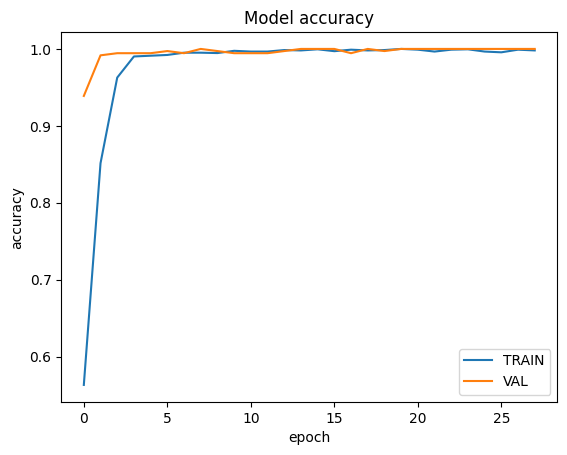

In [95]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [13]:
# Evaluate the model using the TEST dataset
model.load_weights(checkpoint_path)
loss, accuracy = model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 1ms/step - loss: 0.1738 - accuracy: 0.9550


19/19 [==============================] - 0s 750us/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

forward_head       1.00      0.99      0.99       200
     leaning       1.00      1.00      1.00       200
      normal       0.99      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



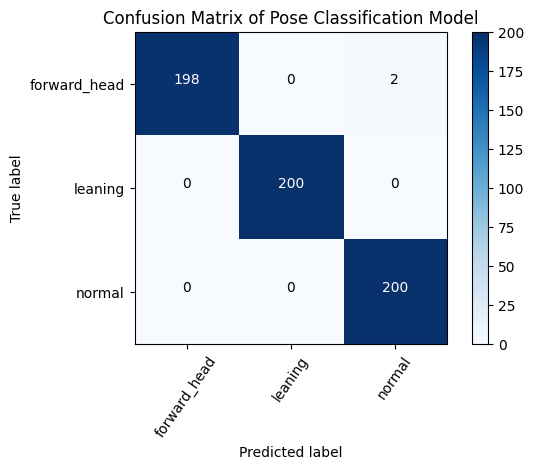

In [61]:
# cm
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

성능이 매우 좋음.

## 해석

정상 자세와 거북목 자세 구분에 매우 미약한 오차 있음. 현대인 대부분이 공통으로 겪는 거북목과 일자목 자세로부터 기인한 것으로 유추함

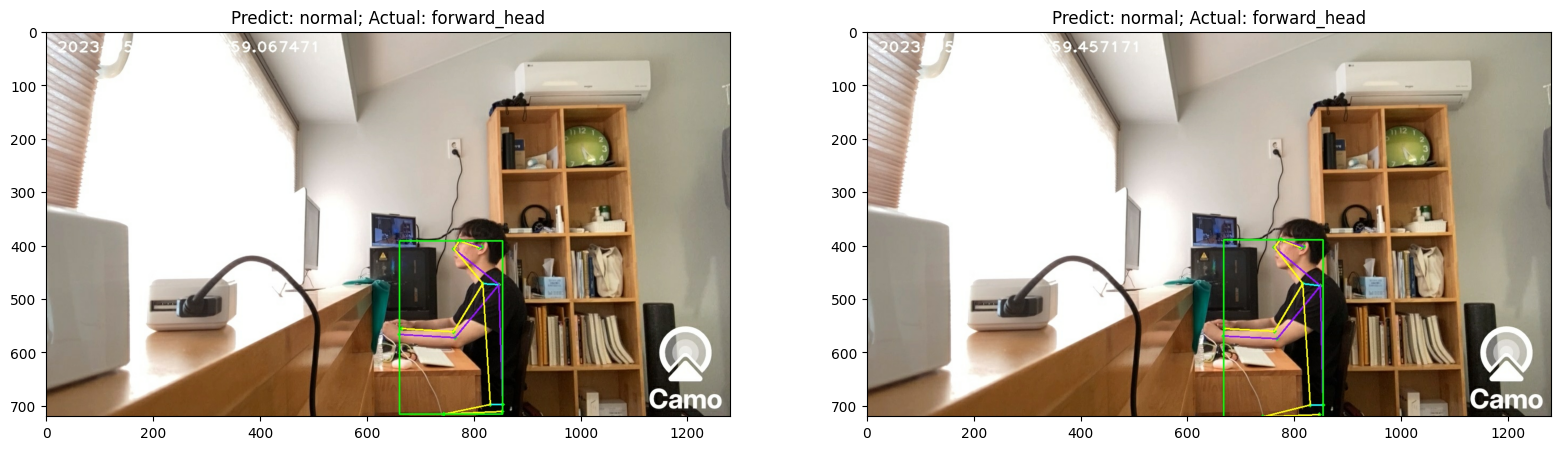

In [64]:
#@title 잘 못 분류된 이미지 출력

IMAGE_PER_ROW = 3
MAX_NO_OF_IMAGE_TO_PLOT = 30

# Extract the list of incorrectly predicted poses
false_predict = [id_in_df for id_in_df in range(len(y_test)) \
                if y_pred_label[id_in_df] != y_true_label[id_in_df]]
if len(false_predict) > MAX_NO_OF_IMAGE_TO_PLOT:
  false_predict = false_predict[:MAX_NO_OF_IMAGE_TO_PLOT]

# Plot the incorrectly predicted images
row_count = len(false_predict) // IMAGE_PER_ROW + 1
fig = plt.figure(figsize=(10 * IMAGE_PER_ROW, 10 * row_count))
for i, id_in_df in enumerate(false_predict):
  ax = fig.add_subplot(row_count, IMAGE_PER_ROW, i + 1)
  image_path = os.path.join(images_out_test_folder,
                            df_test.iloc[id_in_df]['file_name'])

  image = cv2.imread(image_path)
  plt.title("Predict: %s; Actual: %s"
            % (y_pred_label[id_in_df], y_true_label[id_in_df]))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## 실시간 모니터링

In [14]:
from IPython.display import clear_output
import winsound

In [15]:
def real_time_monitor(path=ROOT, x=5000):
    '실시간 모니터링 함수. x miliseconds마다 자세 분류'
    parentdir = os.path.join(path, r'webcam/running/')
    subdir = os.path.join(parentdir, 'live')
    if not os.path.exists(subdir): os.makedirs(subdir)
    os.chdir(subdir)
    
    # i variable is to give unique name to images
    i = 1
    
    wait = 0
    
    # Open the camera
    video = cv2.VideoCapture(0)
    
    
    while True:
        # Read video by read() function and it
        # will extract and  return the frame
        ret, img = video.read()
    
        # Put current DateTime on each frame
        font = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, str(datetime.now()), (20, 40),
                    font, 2, (255, 255, 255), 2, cv2.LINE_AA)
    
        # Display the image
        cv2.imshow('live video', img)
    
        # wait for user to press any key
        key = cv2.waitKey(100)
    
        # wait variable is to calculate waiting time
        wait = wait+100
    
        # press q to quit
        if key == ord('q'):
            # 다음 실행 시 예상치 못한 오류 예방하기 위해 남아있는 현 session assets 삭제
            os.chdir(path)
            shutil.rmtree(subdir, ignore_errors=True)
            break
        # when it reaches to x milliseconds
        # we will save that frame in given folder
        if wait == x:
            filename = 'Frame_'+str(i)+'.jpg'
            
            # Save the images in given path
            cv2.imwrite(filename, img)

            # 캡쳐한 이미지 한 장에 대해 MoveNet 실행
            cur_save_dir = os.path.join(path, r'webcam/current_session')
            csv_out_path = os.path.join(cur_save_dir, f'live_{i}.csv')
            preprocessor = MoveNetPreprocessor(
                images_in_folder=parentdir,
                images_out_folder=cur_save_dir,
                csvs_out_path=csv_out_path,
            )

            preprocessor.process(per_pose_class_limit=None)

            # 분류 모델에 입력할 데이터 생성
            X, _, __, ___ = load_pose_landmarks(csv_out_path)

            # 새로운 이미지에 대해서만 데이터를 생성하도록 이미지 이동
            os.replace(os.path.join(parentdir, f'live/Frame_{i}.jpg'), os.path.join(path, f'webcam/current_session/Frame_{i}.jpg'))

            # 모델 예측결과
            y_pred = model.predict(X)
            y_label = [class_names[i] for i in np.argmax(y_pred, axis=1)][0]

            # 새로운 결과마다 clear output
            clear_output()

            # print output
            print(y_label)

            # 자세 올바르지 않으면 알림음 출력
            # 윈도우 버전으로 구성. 기타 OS 환경에서는 별도로 구현하기 바람
            if y_label != 'normal': winsound.Beep(440, 500)

            i = i+1
            wait = 0
    
    # close the camera
    video.release()
    
    # close open windows
    cv2.destroyAllWindows()
    os.chdir(path)

In [108]:
# 실행
real_time_monitor()

leaning


# 고찰 및 향후 개선사항

- 앞서 언급했듯이 옆모습이 제일 정확하다. 그러기 위해 웹캠을 옆으로 구성해야 하는데, 일상에서 접근 가능한 웹캠은 노트북이나 스마트폰인데, 이것들로 옆 모습을 촬영하기란 여러 가지 문제(노트북으로 작업해야함, 스마트폰 수시로 확인하는 현실, 노트북/스마트폰을 멀리 놔야 옆 모습 확인 가능)로 쉽지 않다. 별도의 웹캠을 구비해야 할텐데, 웹캠비용 대비 고객만족도를 높일 마케팅 전략이 필요하다.
- 모델을 여러 자세로 학습시켜야 하는 분류 문제는 데이터 수집과 학습까지 시간이 오래 걸린다. 정상 자세만 학습시키고 나머지 자세는 이상치로 분류하는 이상치 탐지(Anomaly Detection) 모델은 짧은 기간 안에 학습하는 것이 가능하다. 모델 구조를 여러 가지로 구성해보았으나, 이상치 탐지 모델의 성능은 좋지 않았다. 긴 시간으로 진행되는 프로젝트라면 시도해볼 만하다.
- 앱 개발자와 협업한다면 코드 실행 환경 없이 웹캠으로 간단하게 실행 가능할 것이다.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/pose_classification.ipynb